# Clustering - Sentiment Analysis - Big Richard Club

#### Imports

In [29]:
import pandas as pd
import numpy as np

import re 
import nltk 
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline

from sentence_transformers import SentenceTransformer
import hdbscan
import umap
from sklearn.feature_extraction.text import CountVectorizer

import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None  # default='warn'

# I. Import Data

In [30]:
df_train = pd.read_csv('data/Corona_NLP_train.csv' , encoding = 'latin_1')
df_val = pd.read_csv('data/Corona_NLP_test.csv' , encoding = 'latin_1')

In [31]:
training = df_train[['OriginalTweet', 'Sentiment']]
validation = df_val[['OriginalTweet', 'Sentiment']]

## B) Renaming Columns and Reducing the Amount of Classes

In [32]:
training.rename({
    "OriginalTweet": "text",
    "Sentiment": "label"
}, axis="columns", inplace=True)

validation.rename({
    "OriginalTweet": "text",
    "Sentiment": "label"
}, axis="columns", inplace=True)

#### From 5 classes to 3

In [33]:
def classes_def(x):
    '''
    Makes the label variable have 3 classes instead of 5
    '''
    
    if x ==  "Extremely Positive":
        return "2"
    elif x == "Extremely Negative":
        return "0"
    elif x == "Negative":
        return "0"
    elif x ==  "Positive":
        return "2"
    else:
        return "1"

training['label'] = training['label'].apply(lambda x:classes_def(x))
validation['label'] = validation['label'].apply(lambda x:classes_def(x))

training.label.value_counts(normalize=True)

2    0.438467
0    0.374128
1    0.187404
Name: label, dtype: float64

# II. Data Cleaning

In [34]:
def tokenize_sentence(df, colname):
    df[colname] = df[colname].str.split()
    return df

In [35]:
def remove_stop_words(df, colname):
    stop_words = stopwords.words('english')
    df[colname] = df[colname].apply(lambda x: [word for word in x if word not in stop_words])
    return df

In [36]:
def reverse_tokenize_sentence(df, colname):
    df[colname] = df[colname].map(lambda word: ' '.join(word))
    return df

In [37]:
def big_removal(df, column):
    """
    Takes in a string of text, lowercases it and removes the following elements:
    1. URLs
    2. Mentions "@" and Usernames
    3. HTML
    4. Numbers
    5. Punctuation
    6. Hashtags
    Optional : 7. Extra Space
    """
    
    df[column] = df[column].str.lower()
    
    for i in range(len(df)):
        df[column][i] = re.sub(r'https?://\S+|www\.\S+', "", df[column][i]) # urls
        df[column][i] = re.sub(r"@\w+", "", df[column][i]) # mentions
        df[column][i] = re.sub(r"<.*?>", "", df[column][i]) # html
        df[column][i] = re.sub(r"\d+", "", df[column][i]) # numbers
        df[column][i] = re.sub(r"[^\w\s\d]", "", df[column][i]) # punctuation
        df[column][i] = re.sub(r"#\w+", "", df[column][i]) # hashtags
        #df[column][i] = re.sub(r"\s+", "", df[column][i]) # extra space
    
    return df

In [38]:
def text_cleaning(df, colname):
    """
    Takes in a string of text, then performs the following:
    1. Tokenize sentences
    2. Remove all stopwords
    3. convert tokenized text to text
    """
    
    df = (
        df
        .pipe(tokenize_sentence, colname)
        .pipe(remove_stop_words, colname)
        .pipe(reverse_tokenize_sentence, colname)
    )
    
    return df

In [39]:
big_removal(training, "text")

,text,label
0,and and,1
1,advice talk to your neighbours family to excha...,2
2,coronavirus australia woolworths to give elder...,2
3,my food stock is not the only one which is emp...,2
4,me ready to go at supermarket during the covid...,0
...,...,...
41152,airline pilots offering to stock supermarket s...,1
41153,response to complaint not provided citing covi...,0
41154,you know itâs getting tough when is rationin...,2
41155,is it wrong that the smell of hand sanitizer i...,1


In [40]:
text_cleaning(training, "text")

,text,label
0,,1
1,advice talk neighbours family exchange phone n...,2
2,coronavirus australia woolworths give elderly ...,2
3,food stock one empty please dont panic enough ...,2
4,ready go supermarket covid outbreak im paranoi...,0
...,...,...
41152,airline pilots offering stock supermarket shel...,1
41153,response complaint provided citing covid relat...,0
41154,know itâs getting tough rationing toilet paper...,2
41155,wrong smell hand sanitizer starting turn coron...,1


# III. Clustering

## A) The Clusters

#### all-MiniLM-L6-v2 Model

In [102]:
# RUN ONLY ONCE

#new_model = SentenceTransformer('all-MiniLM-L6-v2')
#new_embeddings = new_model.encode(training["text"], show_progress_bar=True)
#np.savetxt("data/new_training_embeddings.txt.gz", new_embeddings)

Batches:   0%|          | 0/1287 [00:00<?, ?it/s]

In [2]:
embeddings = np.loadtxt("data/new_training_embeddings.txt.gz")

In [3]:
umap_new_embeddings = umap.UMAP(
    n_neighbors=10,
    n_components=10,
    metric='cosine'
).fit_transform(embeddings)

In [4]:
umap_new_embeddings.shape

(41157, 10)

In [7]:
cluster = hdbscan.HDBSCAN(
    min_cluster_size=15,
    metric='euclidean',
    cluster_selection_method='eom'
).fit(umap_new_embeddings)

#### Plot the Clusters

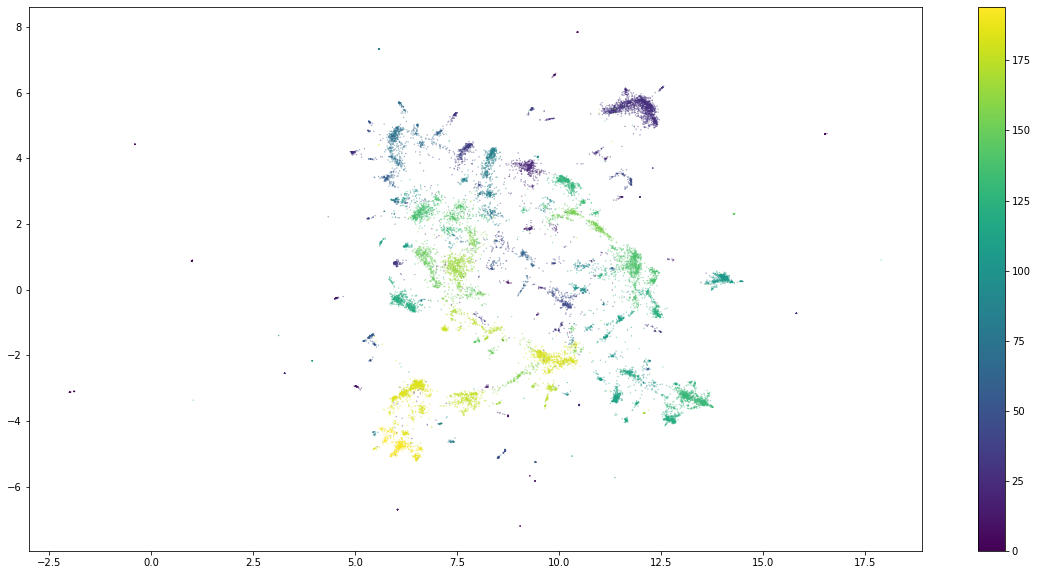

In [9]:
# Prepare data
umap_data = umap.UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
#plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='viridis')
plt.colorbar()

## B) Main words in each Cluster

In [41]:
docs_df = pd.DataFrame(training["text"], columns=["text"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'text': ' '.join})

We define a function which gives us the most common word in a cluster : C-TFIDF 

Source: https://towardsdatascience.com/topic-modeling-with-bert-779f7db187e6 

In [42]:
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(
        ngram_range=ngram_range,
        stop_words="english"
    ).fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(
        np.divide(m, sum_t)
    ).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.text.values, m=len(training))

In [43]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .text
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "text": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=5)

In [44]:
topic_sizes = extract_topic_sizes(docs_df)

#### Top Words in Different Clusters:

In [45]:
top_n_words[-1]

[('covid', 0.02123890141220711),
 ('supermarket', 0.02120954756894196),
 ('coronavirus', 0.020198168184534352),
 ('food', 0.019076703102689288),
 ('grocery', 0.018653418350701563)]

In [50]:
top_n_words[10]

[('ads', 0.4453035771823451),
 ('facebook', 0.4308188488316778),
 ('misinformation', 0.16701127170467286),
 ('reject', 0.14506493248708144),
 ('reports', 0.110897411125614)]

In [47]:
top_n_words[50]

[('service', 0.26736000570864155),
 ('pay', 0.23020042589842177),
 ('workers', 0.20923643456024502),
 ('university', 0.18645074576885343),
 ('laid', 0.1617853822894979)]